In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_gaussian_quantiles
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
import seaborn as sns
import warnings

# Escenario 1: Clasificación binaria vs. multiclase

El campo del aprendizaje automático ha transformado radicalmente la forma en que abordamos problemas complejos en diversos campos. La categorización de datos en clases o categorías específicas es una de las tareas fundamentales del aprendizaje automático. La clasificación multiclase amplía el concepto de la clasificación binaria al gestionar más de dos clases[1].

**Clasificación binaria**

En una tarea de clasificación binaria, el objetivo es clasificar los datos de entrada en dos categorías mutuamente excluyentes. En este caso, los datos de entrenamiento se etiquetan en formato binario: verdadero y falso; positivo y negativo; 0 y 1; spam y no spam, etc., según el problema abordado. Por ejemplo, si se quiere detectar si una imagen dada es un gato o un perro. 

Los algoritmos de regresión logística y máquinas de vectores de soporte están diseñados originalmente para clasificaciones binarias. Sin embargo, otros algoritmos, como los de K-Vecinos Más Próximos y los árboles de decisión, también pueden utilizarse para la clasificación binaria. 

**Clasificación multiclase**

La clasificación multiclase, por otro lado, tiene al menos dos etiquetas de clase mutuamente excluyentes, cuyo objetivo es predecir a qué clase pertenece un ejemplo de entrada dado. En el siguiente caso, el modelo clasificó correctamente la imagen como un plano. 

La mayoría de los algoritmos de clasificación binaria también pueden utilizarse para la clasificación multiclase. Estos algoritmos incluyen, entre otros:

- Bosque aleatorio
- Bayes ingenuo 
- K-Vecinos más cercanos 
- Aumento de gradiente 
- SVM
- Regresión logística.

Es posible aplicar enfoques de transformación binaria, como uno contra uno y uno contra todos, para adaptar los algoritmos nativos de clasificación binaria a tareas de clasificación multiclase[2].


### El conjunto Blobs

Scikit-learn ofrece la función sklearn.datasets.make_blobs que permite la generación de "gotas" (clusters) de datos con distribución gausiana e isotrópica[3].

Es posible definir el número de puntos a generar, el número de clusters, especificar los centros, la desviación estandar de los clusters generados, etc.

Por ejemplo, podemos generar dos clusters de 300 puntos cada uno, con una desviación estándar de 1.0 y 0.5 respectivamente, y centros en las coordenadas (0, 0) y (1, 1) respectivamente. 

**Parametros:**

- **n_samples:** número total de puntos.
- **n_features:** número de variables (dimensiones).
- **centers:** cantidad de centros, o bien coordenadas de los centros.
- **cluster_std:** desviación estándar (qué tan dispersos están los puntos alrededor de cada centro).
- **random_state:** semilla para reproducibilidad.

Puede ser Binario o multiclase: si se define centers=2, se tendrá clasificación binaria; si se define centers=3, será multiclase.

Los blobs son linealmente separables si la dispersión (cluster_std) es baja. Si se aumenta cluster_std, los clusters empiezan a solaparse y la clasificación se hace más difícil.


### Generación de conjuntos de datos

Se generan tres datasets sintéticos distintos usando make_blobs. Cada dataset tendrá un número diferente de clases (clusters): Dataset A : 2 clases (binario), Dataset B : 5 clases, Dataset C : 20 clases. 

Cada data set se divide en Train (60%) / Dev (20%) / Test (20%).

Donde los datos de entrenamiento (train): el modelo aprende sus parámetros aquí. Los datos de Desarrollo/validación (dev): se usa para ajustar hiperparámetros, comparar algoritmos y prevenir sobreajuste, y los de  prueba (test): se mantiene “escondido” hasta el final para medir el rendimiento real del modelo.

Finalmente, se visualiza de forma comparativa para ver cómo queda la separación de conjuntos en cada caso.

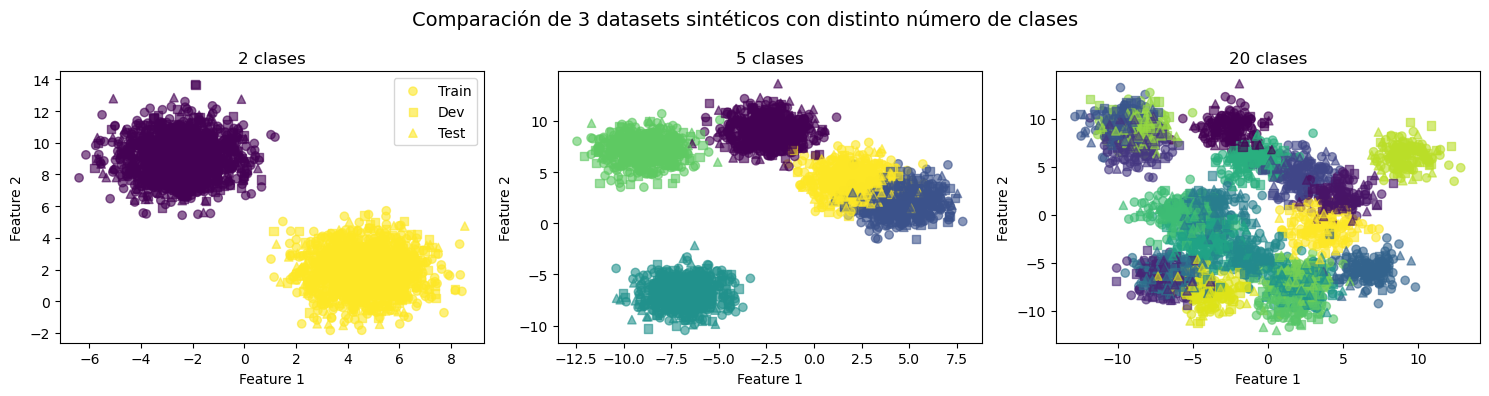

In [19]:
def split_and_plot(n_samples, centers, subplot_index):
    # 1. Generar dataset sintético con "centers" clases
    X, y = make_blobs(n_samples=n_samples, centers=centers, cluster_std=1.2, random_state=42)

    # 2. Dividir en Train (60%) y resto (40%)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.4, stratify=y, random_state=42
    )

    # 3. Dividir el resto en Dev (20%) y Test (20%)
    X_dev, X_test, y_dev, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
    )

    # 4. Visualización
    plt.subplot(1, 3, subplot_index)
    plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap="viridis", marker="o", alpha=0.6, label="Train")#alpha define transparencia en los puntos 
    plt.scatter(X_dev[:,0], X_dev[:,1], c=y_dev, cmap="viridis", marker="s", alpha=0.6, label="Dev")
    plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap="viridis", marker="^", alpha=0.6, label="Test")
    plt.title(f"{centers} clases")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    if subplot_index == 1:  # Solo mostrar leyenda en el primer gráfico
        plt.legend()

plt.figure(figsize=(15, 4))

# Dataset A: 2 clases
split_and_plot(n_samples=3000, centers=2, subplot_index=1)

# Dataset B: 3 clases
split_and_plot(n_samples=3000, centers=5, subplot_index=2)

# Dataset C: 5 clases
split_and_plot(n_samples=3000, centers=20, subplot_index=3)

plt.suptitle("Comparación de 3 datasets sintéticos con distinto número de clases", fontsize=14)
plt.tight_layout()
plt.show()

### Selección del modelo

In [38]:
def generate_multiple_datasets(n_samples=3000, centers_list=[2,3,5], cluster_std=1.2, random_state=42):
    datasets = {}
    for centers in centers_list:
        X, y = make_blobs(n_samples=n_samples, centers=centers, cluster_std=cluster_std, random_state=random_state)
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=random_state)
        X_dev, X_test,  y_dev,  y_test  = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=random_state)
        datasets[centers] = {"X_train": X_train, "y_train": y_train,
                             "X_dev":   X_dev,   "y_dev":   y_dev,
                             "X_test":  X_test,  "y_test":  y_test}
    return datasets

In [40]:
# --- modelos a comparar (con escalado donde aplica) ---
def get_models():
    return {        
        "KNN":    Pipeline([("scaler", StandardScaler()), ("clf", KNeighborsClassifier(n_neighbors=5))]),
        "SVM-RBF":Pipeline([("scaler", StandardScaler()), ("clf", SVC(kernel="rbf"))]),
        "DecisionTree": DecisionTreeClassifier(max_depth=5, random_state=42),                    
        "MLP":   Pipeline([("scaler", StandardScaler()), ("clf", MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42))]),
    }

In [52]:
datasets = generate_multiple_datasets(n_samples=12000, centers_list=[2,5,20], cluster_std=1.2, random_state=42)
models = get_models()

rows = []
for k_classes, data in datasets.items():
    X_train, y_train = data["X_train"], data["y_train"]
    X_test,  y_test  = data["X_test"],  data["y_test"]
    for name, clf in models.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1m = f1_score(y_test, y_pred, average="macro")
        f1w = f1_score(y_test, y_pred, average="weighted")
        rows.append({"dataset_classes": k_classes, "model": name, "accuracy": acc, "f1_macro": f1m, "f1_weighted": f1w})

results = pd.DataFrame(rows).sort_values(["dataset_classes","f1_macro"], ascending=[True, False])
print(results)

# Vista rápida por dataset (mejor f1_macro)
print("\nTop por dataset (f1_macro):")
print(results.loc[results.groupby("dataset_classes")["f1_macro"].idxmax(), ["dataset_classes","model","f1_macro","accuracy"]])

    dataset_classes         model  accuracy  f1_macro  f1_weighted
0                 2           KNN  1.000000  1.000000     1.000000
1                 2       SVM-RBF  1.000000  1.000000     1.000000
2                 2  DecisionTree  1.000000  1.000000     1.000000
3                 2           MLP  1.000000  1.000000     1.000000
7                 5           MLP  0.967917  0.967916     0.967916
5                 5       SVM-RBF  0.966667  0.966666     0.966666
4                 5           KNN  0.962500  0.962497     0.962497
6                 5  DecisionTree  0.947083  0.947178     0.947178
9                20       SVM-RBF  0.746250  0.742135     0.742135
11               20           MLP  0.744167  0.736420     0.736420
8                20           KNN  0.710000  0.708210     0.708210
10               20  DecisionTree  0.674167  0.636940     0.636940

Top por dataset (f1_macro):
   dataset_classes    model  f1_macro  accuracy
0                2      KNN  1.000000  1.000000
7   

#### Hiper-parámetros para KNN 

KNN, o K-Vecinos más Cercanos, es un algoritmo de aprendizaje supervisado que se puede usar tanto para clasificación como para regresión. En esencia, clasifica un nuevo punto de datos basándose en la mayoría de votos de sus 'k' vecinos más cercanos.

Ahora, para controlar cómo se comporta el algoritmo, se usan ciertos hiperparámetros

Los dos hiperparámetros más importantes en KNN son: el número de vecinos (k) y la métrica de distancia.

El parametro K Simplemente le dice al algoritmo cuántos vecinos cercanos debe mirar para tomar una decisión. 

Si k=1, solo se mira al vecino más cercano se adopta su identidad, si k=5, se miran sus 5 vecinos más cercanos y se toma la identidad que sea más común entre ellos (la mayoría de votos).

El valor de k tiene un gran impacto un k pequeño (como 1 o 3) hace que el modelo sea muy sensible a los datos locales. Puede capturar patrones complejos, pero también es muy vulnerable al ruido (puntos de datos aleatorios o erróneos).

Un k grande (como 15 o 21) hace que el modelo sea más general y estable, ya que considera más "opiniones". Sin embargo, si es demasiado grande, podría ignorar patrones locales importantes y simplificar demasiado el problema. Entonces, elegir el valor correcto de "k" es un acto de equilibrio.

La métrica de distancia es la "regla" que usa KNN para medir qué tan cerca o lejos están dos puntos de datos. Es como decidir si para ir a la a un punto a se va a medir la distancia en línea recta.

Las dos métricas de distancia más comunes son:

Distancia Euclidiana: Es la distancia en línea recta entre dos puntos. Es la más utilizada y funciona bien en la mayoría de los casos.

Distancia de Manhattan: También conocida como "distancia de la ciudad". Mide la distancia como si se moviera por una cuadrícula.

In [55]:
pipe_knn = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

param_grid = {
    "knn__n_neighbors": [1, 3, 5, 7, 9, 15, 21],
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["minkowski"],   # dejamos minkowski y movemos p
    "knn__p": [1, 2]                # 1=manhattan, 2=euclídea
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gcv = GridSearchCV(
    pipe_knn,
    param_grid=param_grid,
    scoring="f1_macro",   # o 'accuracy', 'f1_weighted' según tu objetivo
    cv=cv,
    n_jobs=-1
)
gcv.fit(X_train, y_train)

print("Mejores params:", gcv.best_params_)
print("Mejor score CV:", round(gcv.best_score_, 3))

# Evalúa en DEV o TEST (según tu protocolo)
from sklearn.metrics import classification_report
y_pred = gcv.predict(X_dev)  # o X_test
print(classification_report(y_dev, y_pred))

Mejores params: {'knn__metric': 'minkowski', 'knn__n_neighbors': 21, 'knn__p': 2, 'knn__weights': 'uniform'}
Mejor score CV: 0.724
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       200
           1       0.81      0.83      0.82       200
           2       0.58      0.62      0.60       200
           3       0.65      0.68      0.66       200
           4       0.85      0.81      0.83       200
           5       0.57      0.61      0.59       200
           6       0.88      0.95      0.92       200
           7       0.52      0.40      0.45       200
           8       0.71      0.71      0.71       200
           9       0.83      0.81      0.82       200
          10       0.42      0.36      0.39       200
          11       0.79      0.80      0.79       200
          12       0.85      0.86      0.85       200
          13       0.73      0.78      0.76       200
          14       0.68      0.78      0.72       200
    

#### Hiper-parámetros para árbol de decisión 

Un Árbol de Decisión es como un diagrama de flujo donde cada "nodo" es una pregunta sobre los datos (por ejemplo, "¿la edad es mayor a 30?"). El objetivo es seguir un camino de preguntas hasta llegar a una "hoja" que nos da la predicción final.

Los hiperparámetros de un árbol ayudan a controlar qué tan grande y complejo se vuelve este diagrama de flujo. El objetivo principal es evitar que el árbol se aprenda los datos de entrenamiento de memoria, lo que se conoce como sobreajuste.

Entre los hiperparámetros tenemos el criterio el cual le dice al árbol cómo decidir cuál es la mejor pregunta para hacer en cada paso. 

El árbol quiere hacer preguntas que separen los datos de la forma más "pura" posible, dejando grupos donde la mayoría de los miembros sean de la misma clase.

Para medir esa "pureza", se tienen dos opciones principales:

Gini Impurity (Impureza de Gini): Mide la probabilidad de que si se elige un elemento al azar del grupo, lo clasifica incorrectamente. Un valor de 0 es perfecto (todos son de la misma clase).

Entropy (Entropía): Es un concepto de la teoría de la información que mide el desorden o la incertidumbre en un grupo. Al igual que con Gini, un valor de 0 significa que no hay desorden (todos son de la misma clase).

En la práctica, Gini y Entropía suelen dar resultados muy similares. Gini es un poco más rápido de calcular, por lo que a menudo es la opción por defecto.

El parametro de profundidad (depth) es como ponerle un límite al árbol. Le dice: "No puedes hacer más de 'X' preguntas en una fila para llegar a una conclusión".

Controla la longitud máxima de cualquier camino desde la raíz (la primera pregunta) hasta una hoja (la predicción final).

Un max_depth pequeño (por ejemplo, 2 o 3) crea un árbol muy simple y chaparro. Es fácil de entender, pero podría no ser lo suficientemente detallado para capturar toda la información de los datos. A esto se le llama subajuste (underfitting).

Un max_depth grande (o no ponerle límite) permite que el árbol crezca mucho, haciendo preguntas muy específicas hasta que cada dato de entrenamiento esté perfectamente clasificado.


El hiperparámetro min_samples_split establece el número mínimo de ejemplos que debe tener un nodo para que se le permita dividirse y seguir haciendo preguntas.

Si se establece min_samples_split=10, el árbol solo podrá hacer una nueva pregunta si el nodo actual tiene 10 o más ejemplos.

Si un nodo tiene 9 ejemplos, ya no podrá dividirse y se convertirá en una hoja (una respuesta final), incluso si su profundidad es menor que max_depth.

Este hiperparámetro es otra excelente herramienta para evitar el sobreajuste. Ayuda a impedir que el árbol se esfuerce en crear reglas súper específicas para grupos muy pequeños de datos.

In [56]:
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 3, 5, 7],
    "min_samples_split": [2, 10, 20],
    "min_samples_leaf": [1, 5, 20], #mínimo de muestras en cada hoja. Evita hojas diminutas (ruido).
    "max_features": [None, "sqrt", "log2"], #nº de variables candidatas por división. Limitarlo introduce regularización.
    "class_weight": [None, "balanced"],# "balanced" si hay desbalance de clases.
    "ccp_alpha": [0.0, 0.001, 0.01], # pruning cost–complexity (poda post-entrenamiento). >0 recorta ramas débiles.
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rows = []
best_models = {}

for k_classes, d in datasets.items():
    Xtr, ytr = d["X_train"], d["y_train"]
    Xdv, ydv = d["X_dev"],   d["y_dev"]
    Xte, yte = d["X_test"],  d["y_test"]

    # Base (por defecto)
    base = DecisionTreeClassifier(random_state=42)
    base.fit(Xtr, ytr)
    yhat_dv_base = base.predict(Xdv)
    base_acc = accuracy_score(ydv, yhat_dv_base)
    base_f1m = f1_score(ydv, yhat_dv_base, average="macro")
    base_f1w = f1_score(ydv, yhat_dv_base, average="weighted")

    # Optimizado (GridSearch en DEV)
    gcv = GridSearchCV(DecisionTreeClassifier(random_state=42),
                       param_grid=param_grid, scoring="f1_macro",
                       cv=cv, n_jobs=-1, refit=True)
    gcv.fit(Xtr, ytr)
    best = gcv.best_estimator_
    yhat_dv_best = best.predict(Xdv)
    best_acc = accuracy_score(ydv, yhat_dv_best)
    best_f1m = f1_score(ydv, yhat_dv_best, average="macro")
    best_f1w = f1_score(ydv, yhat_dv_best, average="weighted")

    rows.append({
        "dataset_classes": k_classes,
        "model": "DT-Default", "split": "DEV",
        "accuracy": base_acc, "f1_macro": base_f1m, "f1_weighted": base_f1w
    })
    rows.append({
        "dataset_classes": k_classes,
        "model": "DT-Optimized", "split": "DEV",
        "accuracy": best_acc, "f1_macro": best_f1m, "f1_weighted": best_f1w
    })

    # Guarda el mejor para test
    best_models[k_classes] = best

# Evaluación final en TEST con el optimizado
for k_classes, d in datasets.items():
    Xte, yte = d["X_test"], d["y_test"]
    best = best_models[k_classes]
    yhat_te = best.predict(Xte)
    rows.append({
        "dataset_classes": k_classes,
        "model": "DT-Optimized", "split": "TEST",
        "accuracy": accuracy_score(yte, yhat_te),
        "f1_macro": f1_score(yte, yhat_te, average="macro"),
        "f1_weighted": f1_score(yte, yhat_te, average="weighted")
    })
    # (opcional) reporte detallado
    # print(f"\n=== TEST {k_classes} clases ===")
    # print(classification_report(yte, yhat_te))

results = pd.DataFrame(rows).sort_values(["dataset_classes","split","f1_macro"], ascending=[True, True, False])
print(results)

# Vista rápida: ganador en DEV por dataset
print("\nTop DEV por dataset:")
print(results[results["split"]=="DEV"].loc[results[results["split"]=="DEV"].groupby("dataset_classes")["f1_macro"].idxmax(),
      ["dataset_classes","model","accuracy","f1_macro"]])

   dataset_classes         model split  accuracy  f1_macro  f1_weighted
0                2    DT-Default   DEV  1.000000  1.000000     1.000000
1                2  DT-Optimized   DEV  1.000000  1.000000     1.000000
6                2  DT-Optimized  TEST  1.000000  1.000000     1.000000
3                5  DT-Optimized   DEV  0.961250  0.961143     0.961143
2                5    DT-Default   DEV  0.946250  0.946140     0.946140
7                5  DT-Optimized  TEST  0.960000  0.959983     0.959983
5               20  DT-Optimized   DEV  0.720417  0.717556     0.717556
4               20    DT-Default   DEV  0.662083  0.661658     0.661658
8               20  DT-Optimized  TEST  0.727083  0.725107     0.725107

Top DEV por dataset:
   dataset_classes         model  accuracy  f1_macro
0                2    DT-Default  1.000000  1.000000
3                5  DT-Optimized  0.961250  0.961143
5               20  DT-Optimized  0.720417  0.717556


Se tienen datasets (2, 5 y 20 clases) donde se quere comparar un árbol simple por defecto vs. un árbol optimizado con GridSearchCV.

Se evalúan ambos en el conjunto de desarrollo (DEV). Luego se usa el mejor modelo optimizado para evaluar en TEST. Esto simula un flujo real: entrenar , validar , seleccionar , testear.

**GridSearchCV:** prueba varias combinaciones de: 

- Criterio de impureza: gini vs entropía.
- Profundidad máxima (max_depth): hasta 7 niveles o ilimitado (None).
- Tamaño mínimo de división/hoja: regularizan contra el sobreajuste.
- max_features: cuántas variables usar al dividir.
- class_weight: útil si hay desbalance.
- ccp_alpha: poda post-entrenamiento.

Esto permite encontrar un árbol menos sobreajustado y más generalizable.

**Interpretación esperada**

- DT-Default (DEV): suele sobreajustar, especialmente si el dataset tiene ruido o varias clases.
- DT-Optimized (DEV): debería mejorar F1 macro (porque los hiperparámetros limitan sobreajuste).
- DT-Optimized (TEST): este es el resultado final que realmente importa: qué tan bien generaliza.































#### Hiper-parámetros para SVM

La idea principal de un SVM es encontrar la "calle" o el "margen" más ancho posible que separe perfectamente dos clases de datos. Los puntos que están justo en el borde de esta calle se llaman vectores de soporte, y son los que definen dónde se dibuja la línea de separación.

Los hiperparámetros nos ayudan a definir cómo de ancha y flexible puede ser esta calle, y qué hacer si algunos puntos se "meten" en ella.

Los más importantes son C: El parámetro de regularización, el kernel: El tipo de "calle" o frontera que vamos a dibujar, y  gamma: La influencia que tiene cada punto de entrenamiento.

Son todos importantes, pero C y kernel son los que definen el comportamiento fundamental del modelo.

El parámetro C es fundamental porque controla el balance entre el error y la simplicidad del modelo. 

Un C alto penaliza mucho los errores. El modelo se esfuerza por clasificar cada punto de entrenamiento correctamente, lo que puede llevar a un sobreajuste, por otro lado un C bajo Es más tolerante con los errores. Busca un margen más amplio y un modelo más general, lo que puede ser mejor para datos nuevos, aunque no sea perfecto con los de entrenamiento.


El kernel es una función matemática que nos permite crear fronteras de decisión mucho más complejas y flexibles.

si no es posible separar los datos en su dimensión actual, el kernel los proyecta a una dimensión superior donde sí se puedan separar con una línea (o un plano).

Por ejemplo si se tienen puntos azules y rojos mezclados en una hoja de papel (2D). El "truco" sería como lanzar la hoja al aire de tal forma que todos los puntos azules queden por arriba y los rojos por abajo. 




In [57]:
# --- SVM con scaling y GridSearch ---
pipe_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(probability=False))  # para velocidad; si quieres ROC, usa True
])

param_grid = [
    {"svm__kernel": ["linear"], "svm__C": [0.1, 1, 10, 100]},#frontera recta, útil si las clases son linealmente separables.
    {"svm__kernel": ["rbf"],    "svm__C": [0.1, 1, 10, 100], "svm__gamma": ["scale", 0.1, 0.01, 0.001]},# frontera flexible, buena para problemas no lineales.
    # opcional: polinomial (suele ser más lento)
    # {"svm__kernel": ["poly"], "svm__degree":[2,3], "svm__C":[0.1,1,10], "svm__gamma":["scale", 0.1]}
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rows = []
best_models = {}

for k_classes, d in datasets.items():
    Xtr, ytr = d["X_train"], d["y_train"]
    Xdv, ydv = d["X_dev"],   d["y_dev"]
    Xte, yte = d["X_test"],  d["y_test"]

    gcv = GridSearchCV(
        estimator=pipe_svm,
        param_grid=param_grid,
        scoring="f1_macro",   # multiclase: trata las clases por igual
        cv=cv,
        n_jobs=-1,
        refit=True,
        verbose=0
    )
    gcv.fit(Xtr, ytr)
    best = gcv.best_estimator_
    best_models[k_classes] = best

    # Evaluación en DEV
    yhat_dv = best.predict(Xdv)
    rows.append({
        "dataset_classes": k_classes, "model": "SVM-Optimized", "split": "DEV",
        "accuracy": accuracy_score(ydv, yhat_dv),
        "f1_macro": f1_score(ydv, yhat_dv, average="macro"),
        "f1_weighted": f1_score(ydv, yhat_dv, average="weighted"),
        "best_params": gcv.best_params_
    })

# Evaluación final en TEST
for k_classes, d in datasets.items():
    Xte, yte = d["X_test"], d["y_test"]
    best = best_models[k_classes]
    yhat_te = best.predict(Xte)
    rows.append({
        "dataset_classes": k_classes, "model": "SVM-Optimized", "split": "TEST",
        "accuracy": accuracy_score(yte, yhat_te),
        "f1_macro": f1_score(yte, yhat_te, average="macro"),
        "f1_weighted": f1_score(yte, yhat_te, average="weighted"),
        "best_params": best.get_params()
    })

results = pd.DataFrame(rows).sort_values(["dataset_classes","split","f1_macro"], ascending=[True, True, False])
print(results)

# Vista rápida: mejor SVM (DEV) por dataset y su rendimiento en TEST
print("\nTop DEV por dataset (SVM):")
print(results[results["split"]=="DEV"].loc[
    results[results["split"]=="DEV"].groupby("dataset_classes")["f1_macro"].idxmax(),
    ["dataset_classes","model","f1_macro","accuracy","best_params"]
])
print("\nResultados TEST (SVM optimizado):")
print(results[results["split"]=="TEST"].sort_values(["dataset_classes","f1_macro"], ascending=[True, False]))

   dataset_classes          model split  accuracy  f1_macro  f1_weighted  \
0                2  SVM-Optimized   DEV  1.000000  1.000000     1.000000   
3                2  SVM-Optimized  TEST  1.000000  1.000000     1.000000   
1                5  SVM-Optimized   DEV  0.968750  0.968720     0.968720   
4                5  SVM-Optimized  TEST  0.966667  0.966665     0.966665   
2               20  SVM-Optimized   DEV  0.752083  0.749915     0.749915   
5               20  SVM-Optimized  TEST  0.749167  0.746107     0.746107   

                                         best_params  
0           {'svm__C': 0.1, 'svm__kernel': 'linear'}  
3  {'memory': None, 'steps': [('scaler', Standard...  
1  {'svm__C': 100, 'svm__gamma': 0.01, 'svm__kern...  
4  {'memory': None, 'steps': [('scaler', Standard...  
2  {'svm__C': 100, 'svm__gamma': 0.001, 'svm__ker...  
5  {'memory': None, 'steps': [('scaler', Standard...  

Top DEV por dataset (SVM):
   dataset_classes          model  f1_macro  accuracy 

Primero se entrena y busca hiperparámetros con train, Luego se evalúa el mejor modelo en DEV (validación), Finalmente se reentrena y se evalúa en TEST.

Métricas:

Accuracy: porcentaje de aciertos.

F1-macro: equilibrio entre precisión y recall en cada clase, promediado de forma igualitaria.

F1-weighted: como macro, pero ponderado por el número de ejemplos de cada clase.

En 2 clases, SVM lineal debería bastar (problema fácil).

En 5 clases, probablemente RBF dé mejor resultado si hay solapamiento.

En 20 clases, el problema es más complejo → RBF con ajuste fino de C y gamma suele rendir mejor.

f1_macro es la métrica clave: si se mantiene alto en 20 clases, significa que el modelo no descuida clases minoritarias.

#### Hiper-parámetros para MLP

Un Perceptrón Multicapa o MLP (Multi-Layer Perceptron) es básicamente un conjunto de "neuronas" organizadas en capas. Los datos entran por la primera capa, pasan por una o más capas ocultas donde ocurre la "magia" del aprendizaje, y finalmente salen por la última capa con una predicción.

Los hiperparámetros de un MLP nos ayudan a definir la arquitectura de esta red y cómo aprende. 

arquitectura de las capas ocultas: Este es probablemente el aspecto más "creativo" de diseñar un MLP. Se refiere a dos decisiones clave:

Número de capas ocultas: ¿Cuántas capas de neuronas habrá entre la entrada y la salida?

Número de neuronas por capa: ¿Qué tan "ancha" será cada una de estas capas?

Sabiendo que una red más grande puede memorizar pero una más pequeña podría no aprender lo suficiente.

Este parámetro funciona por "prueba y error", es la forma más común de encontrar la arquitectura ideal. En el mundo del machine learning, a este proceso estructurado de prueba y error se le suelen llamar búsqueda de hiperparámetros (hyperparameter tuning). 

No hay una fórmula mágica, así que los expertos prueban muchas combinaciones diferentes para ver cuál funciona mejor.

 la función de activación: es una pieza clave. Si las neuronas son los "ladrillos" de la red, la función de activación es lo que decide si un ladrillo se "enciende" y contribuye a la construcción o no.

Después de que una neurona suma todas las señales que le llegan de la capa anterior, pasa el resultado a través de una función de activación. Esta función transforma el número y decide qué tan importante es esa señal para pasarla a la siguiente capa.

Sin estas funciones, una red neuronal, sin importar cuántas capas tenga, se comportaría como un simple modelo lineal. Las funciones de activación introducen la no linealidad que permite a la red aprender patrones increíblemente complejos.

In [58]:
# MLP necesita escalado
pipe_mlp = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(max_iter=500, random_state=42))
])

# Hiperparámetros a explorar
param_grid = {
    "mlp__hidden_layer_sizes": [(50,), (100,), (100,50)],# estructura de la red (nº de neuronas por capa).
    "mlp__activation": ["relu", "tanh"],# función de activación.
    "mlp__alpha": [0.0001, 0.001, 0.01],   # regularización L2 (para evitar sobreajuste).
    "mlp__learning_rate_init": [0.001, 0.01],  # tasa de aprendizaje (para Adam o SGD).
    "mlp__solver": ["adam"]   # dejamos Adam por practicidad optimizador.
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rows = []
best_models = {}

for k_classes, d in datasets.items():
    Xtr, ytr = d["X_train"], d["y_train"]
    Xdv, ydv = d["X_dev"],   d["y_dev"]
    Xte, yte = d["X_test"],  d["y_test"]

    gcv = GridSearchCV(
        pipe_mlp, param_grid=param_grid,
        scoring="f1_macro", cv=cv, n_jobs=-1, refit=True, verbose=0
    )
    gcv.fit(Xtr, ytr)
    best = gcv.best_estimator_
    best_models[k_classes] = best

    # Evaluación en DEV
    yhat_dv = best.predict(Xdv)
    rows.append({
        "dataset_classes": k_classes, "model": "MLP-Optimized", "split": "DEV",
        "accuracy": accuracy_score(ydv, yhat_dv),
        "f1_macro": f1_score(ydv, yhat_dv, average="macro"),
        "f1_weighted": f1_score(ydv, yhat_dv, average="weighted"),
        "best_params": gcv.best_params_
    })

# Evaluación en TEST
for k_classes, d in datasets.items():
    Xte, yte = d["X_test"], d["y_test"]
    best = best_models[k_classes]
    yhat_te = best.predict(Xte)
    rows.append({
        "dataset_classes": k_classes, "model": "MLP-Optimized", "split": "TEST",
        "accuracy": accuracy_score(yte, yhat_te),
        "f1_macro": f1_score(yte, yhat_te, average="macro"),
        "f1_weighted": f1_score(yte, yhat_te, average="weighted"),
        "best_params": best.get_params()["mlp"]
    })

results = pd.DataFrame(rows).sort_values(["dataset_classes","split","f1_macro"], ascending=[True, True, False])
print(results)

# Vista rápida
print("\nTop DEV por dataset (MLP):")
print(results[results["split"]=="DEV"].loc[
    results[results["split"]=="DEV"].groupby("dataset_classes")["f1_macro"].idxmax(),
    ["dataset_classes","model","f1_macro","accuracy","best_params"]
])
print("\nResultados TEST (MLP optimizado):")
print(results[results["split"]=="TEST"].sort_values(["dataset_classes","f1_macro"], ascending=[True, False]))

   dataset_classes          model split  accuracy  f1_macro  f1_weighted  \
0                2  MLP-Optimized   DEV  1.000000  1.000000     1.000000   
3                2  MLP-Optimized  TEST  1.000000  1.000000     1.000000   
1                5  MLP-Optimized   DEV  0.969583  0.969553     0.969553   
4                5  MLP-Optimized  TEST  0.966667  0.966630     0.966630   
2               20  MLP-Optimized   DEV  0.741667  0.735093     0.735093   
5               20  MLP-Optimized  TEST  0.739583  0.732222     0.732222   

                                         best_params  
0  {'mlp__activation': 'relu', 'mlp__alpha': 0.00...  
3  MLPClassifier(hidden_layer_sizes=(50,), max_it...  
1  {'mlp__activation': 'tanh', 'mlp__alpha': 0.01...  
4  MLPClassifier(activation='tanh', alpha=0.01, h...  
2  {'mlp__activation': 'tanh', 'mlp__alpha': 0.01...  
5  MLPClassifier(activation='tanh', alpha=0.01, h...  

Top DEV por dataset (MLP):
   dataset_classes          model  f1_macro  accuracy 

In [69]:
# 3. Evaluación
rows = []
conf_matrices = {}

for k_classes, d in datasets.items():
    Xtr, ytr = d["X_train"], d["y_train"]
    Xte, yte = d["X_test"],  d["y_test"]

    for nombre, modelo in modelos.items():
        modelo.fit(Xtr, ytr)
        ypred = modelo.predict(Xte)

        acc = accuracy_score(yte, ypred)
        prec = precision_score(yte, ypred, average="macro")
        rec = recall_score(yte, ypred, average="macro")
        f1m = f1_score(yte, ypred, average="macro")
        f1w = f1_score(yte, ypred, average="weighted")

        rows.append({
            "dataset_classes": k_classes,
            "model": nombre,
            "accuracy": acc,
            "precision_macro": prec,
            "recall_macro": rec,
            "f1_macro": f1m,
            "f1_weighted": f1w
        })

        # Guardamos la matriz de confusión
        conf_matrices[(k_classes, nombre)] = confusion_matrix(yte, ypred)

# 4. Resultados en tabla
results = pd.DataFrame(rows).sort_values(["dataset_classes","f1_macro"], ascending=[True, False])
print(results)

# 5. Ejemplo: mostrar matrices de confusión de cada modelo en 3 clases
print("\nMATRICES DE CONFUSIÓN (dataset 3 clases):")
for nombre in modelos.keys():
    print(f"\nModelo: {nombre}")
    print(conf_matrices[(20, nombre)])

/home/cristian/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


    dataset_classes         model  accuracy  precision_macro  recall_macro  \
0                 2           KNN  1.000000         1.000000      1.000000   
1                 2  DecisionTree  1.000000         1.000000      1.000000   
2                 2       SVM-RBF  1.000000         1.000000      1.000000   
3                 2           MLP  1.000000         1.000000      1.000000   
6                 5       SVM-RBF  0.969167         0.969221      0.969167   
7                 5           MLP  0.968750         0.968775      0.968750   
4                 5           KNN  0.962500         0.962515      0.962500   
5                 5  DecisionTree  0.947083         0.947430      0.947083   
10               20       SVM-RBF  0.746250         0.743631      0.746250   
11               20           MLP  0.741667         0.737933      0.741667   
8                20           KNN  0.710000         0.709573      0.710000   
9                20  DecisionTree  0.674167         0.645540    

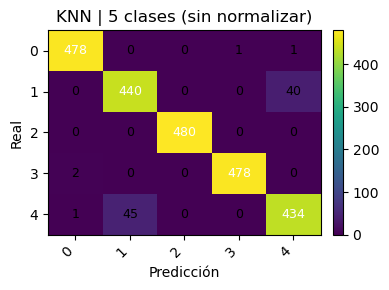

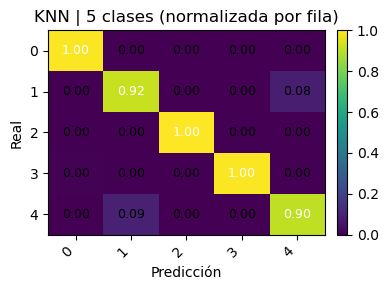

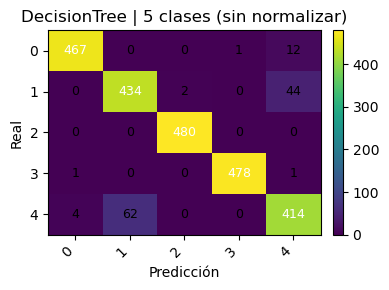

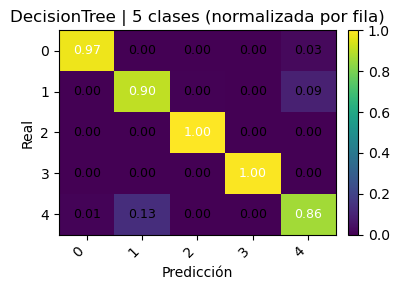

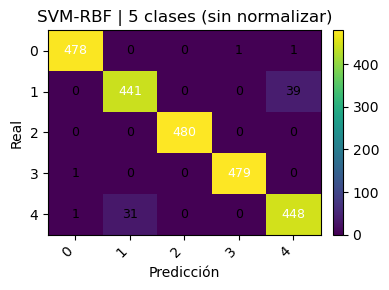

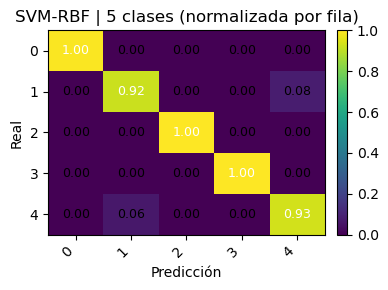

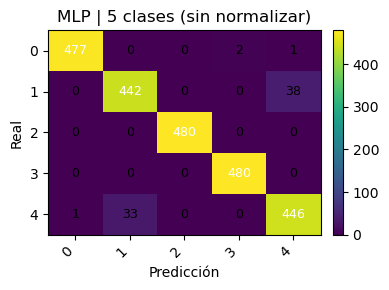

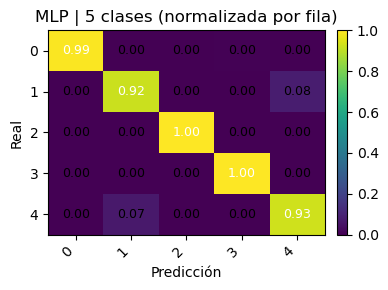

In [74]:
def plot_confusion_heatmap(cm, class_names, title="Matriz de confusión", normalize=False):
    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1, keepdims=True).clip(min=1)
    fig, ax = plt.subplots(figsize=(4,3))
    im = ax.imshow(cm, aspect="auto")
    ax.set_title(title)
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Real")
    ax.set_xticks(range(len(class_names))); ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_yticks(range(len(class_names))); ax.set_yticklabels(class_names)
    # anotaciones
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i, j]:.2f}" if normalize else f"{cm[i, j]}",
                    ha="center", va="center", fontsize=9, color="white" if im.norm(cm[i,j])>0.5 else "black")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

# Ejemplo: mostrar heatmaps para TODOS los modelos del dataset de 3 clases
k = 5
class_names = sorted(np.unique(datasets[k]["y_test"]))
for model_name in modelos.keys():
    cm = conf_matrices[(k, model_name)]
    plot_confusion_heatmap(cm, class_names, title=f"{model_name} | {k} clases (sin normalizar)", normalize=False)
    plot_confusion_heatmap(cm, class_names, title=f"{model_name} | {k} clases (normalizada por fila)", normalize=True)

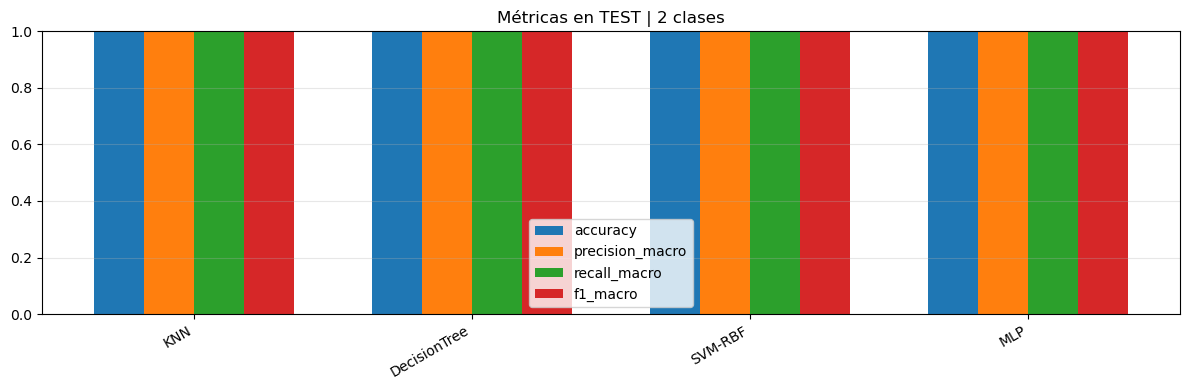

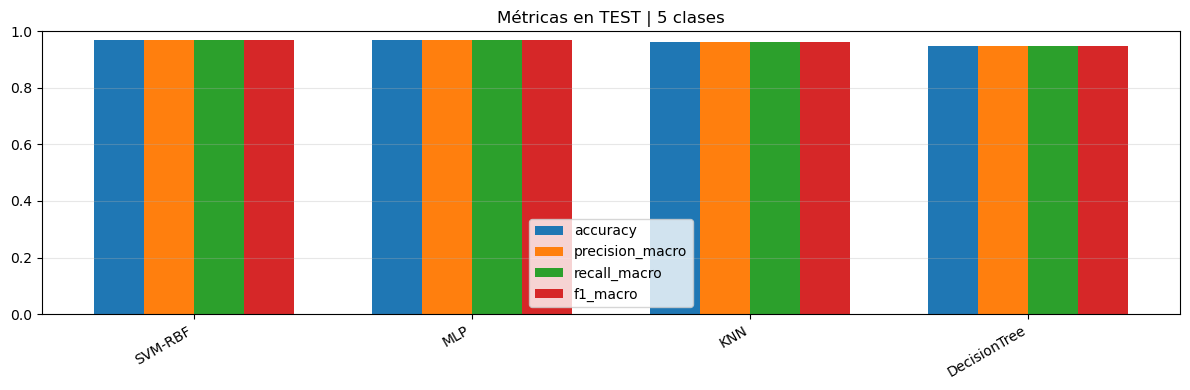

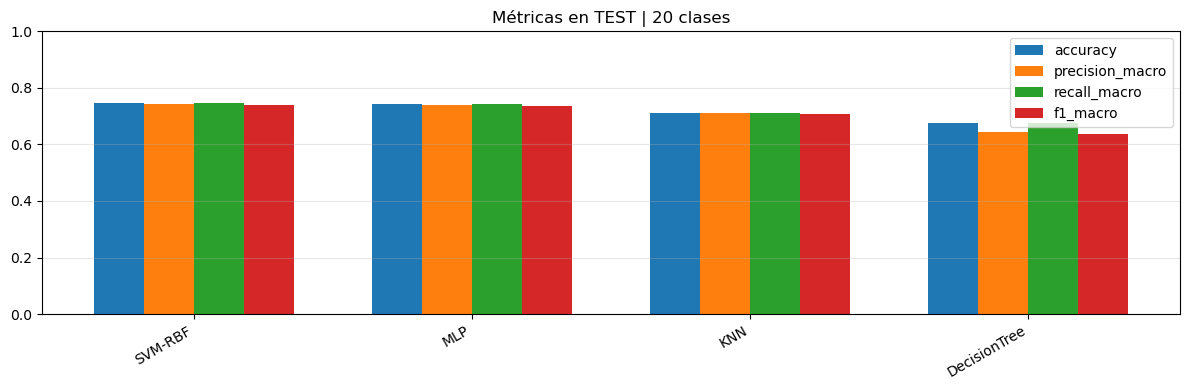

In [75]:
def barplot_metrics(results, k_classes, metrics=("accuracy","precision_macro","recall_macro","f1_macro")):
    df = results[results["dataset_classes"]==k_classes].copy()
    # si tienes filas DEV y TEST, filtra una (ej. TEST) para comparar final
    if "split" in df.columns:
        df = df[df["split"]=="TEST"].copy()
    models = df["model"].tolist()
    x = np.arange(len(models))
    width = 0.18

    fig, ax = plt.subplots(figsize=(12,4))
    for i, m in enumerate(metrics):
        ax.bar(x + i*width, df[m].values, width, label=m)
    ax.set_xticks(x + width*(len(metrics)-1)/2)
    ax.set_xticklabels(models, rotation=30, ha="right")
    ax.set_ylim(0, 1.0)
    ax.set_title(f"Métricas en TEST | {k_classes} clases")
    ax.legend()
    ax.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

# Barras para 2, 3 y 5 clases (puedes cambiar el set de métricas si quieres)
for k in [2,5,20]:
    barplot_metrics(results, k, metrics=("accuracy","precision_macro","recall_macro","f1_macro"))

In [76]:
def plot_decision_boundary(ax, clf, X, y, title=None, proba=False, padding=0.05, grid=300):
    # Rango con pequeño padding
    x_min, x_max = X[:,0].min(), X[:,0].max()
    y_min, y_max = X[:,1].min(), X[:,1].max()
    dx, dy = x_max - x_min, y_max - y_min
    x_min, x_max = x_min - dx*padding, x_max + dx*padding
    y_min, y_max = y_min - dy*padding, y_max + dy*padding

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid),
                         np.linspace(y_min, y_max, grid))
    grid_xy = np.c_[xx.ravel(), yy.ravel()]

    # Predicción en rejilla
    if proba and hasattr(clf, "predict_proba"):
        Z = clf.predict_proba(grid_xy).argmax(1)  # clase más probable
    else:
        Z = clf.predict(grid_xy)
    Z = Z.reshape(xx.shape)

    # Mapa de decisión + puntos
    cs = ax.contourf(xx, yy, Z, alpha=0.25, levels=np.unique(Z).size)
    sc = ax.scatter(X[:,0], X[:,1], c=y, s=20, alpha=0.8)
    ax.set_title(title or type(clf).__name__)
    ax.set_xlabel("Feature 1"); ax.set_ylabel("Feature 2")

def visualize_many_classifiers(classifiers, X, y, cols=3, fit=True):
    """
    classifiers: lista de (nombre, estimator) — usa Pipeline con StandardScaler si el modelo lo necesita.
    X, y: datos 2D (si tienes >2 features, proyecta antes con PCA/UMAP).
    """
    n = len(classifiers)
    rows = int(np.ceil(n/cols))
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3.5*rows))
    axes = np.array(axes).reshape(-1)

    for i, (name, clf) in enumerate(classifiers):
        if fit:
            clf.fit(X, y)
        plot_decision_boundary(axes[i], clf, X, y, title=name)
    # ocultar subplots vacíos
    for j in range(i+1, rows*cols):
        axes[j].axis("off")
    plt.tight_layout(); plt.show()

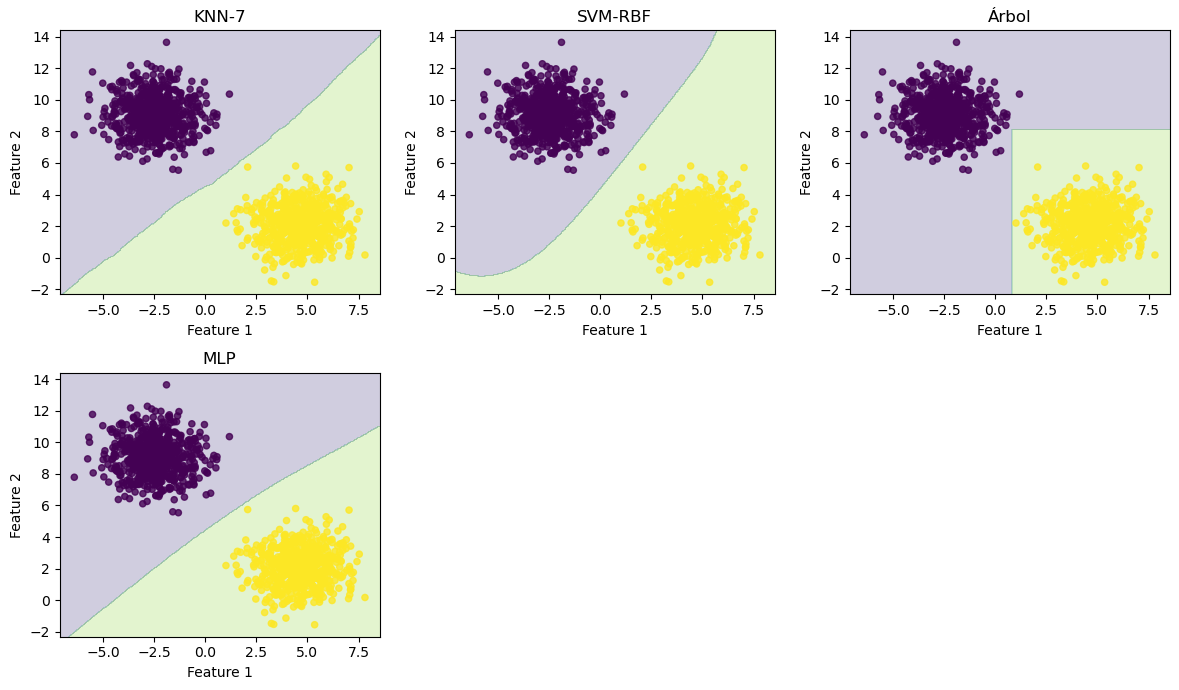

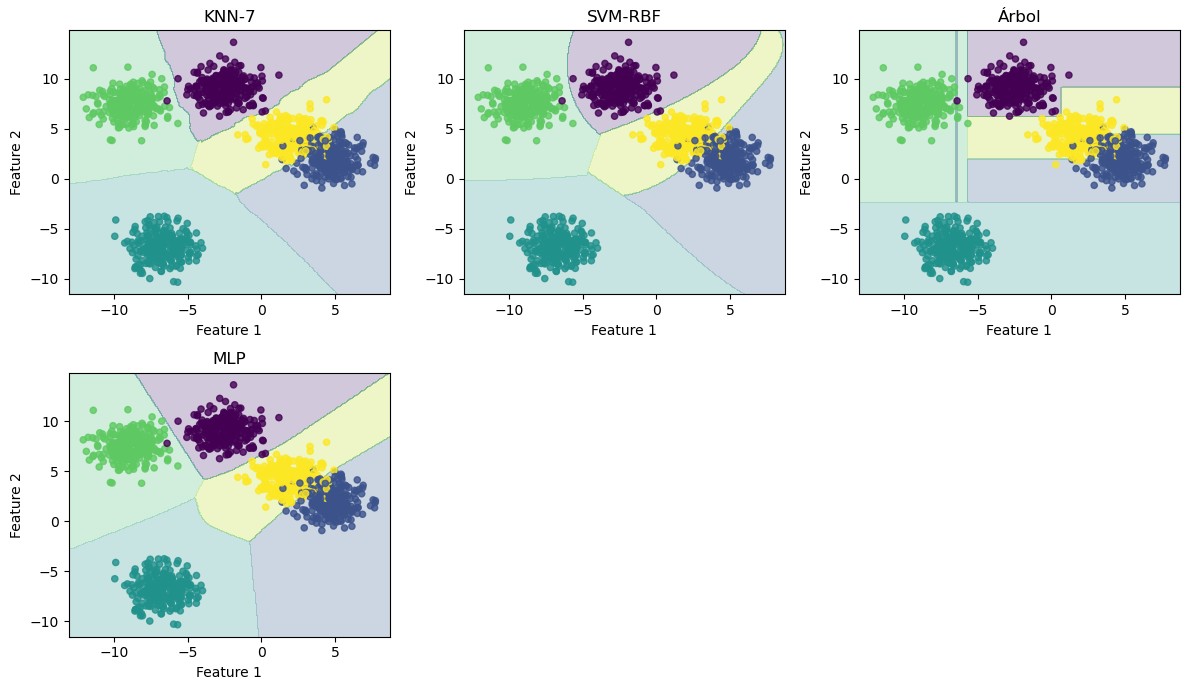

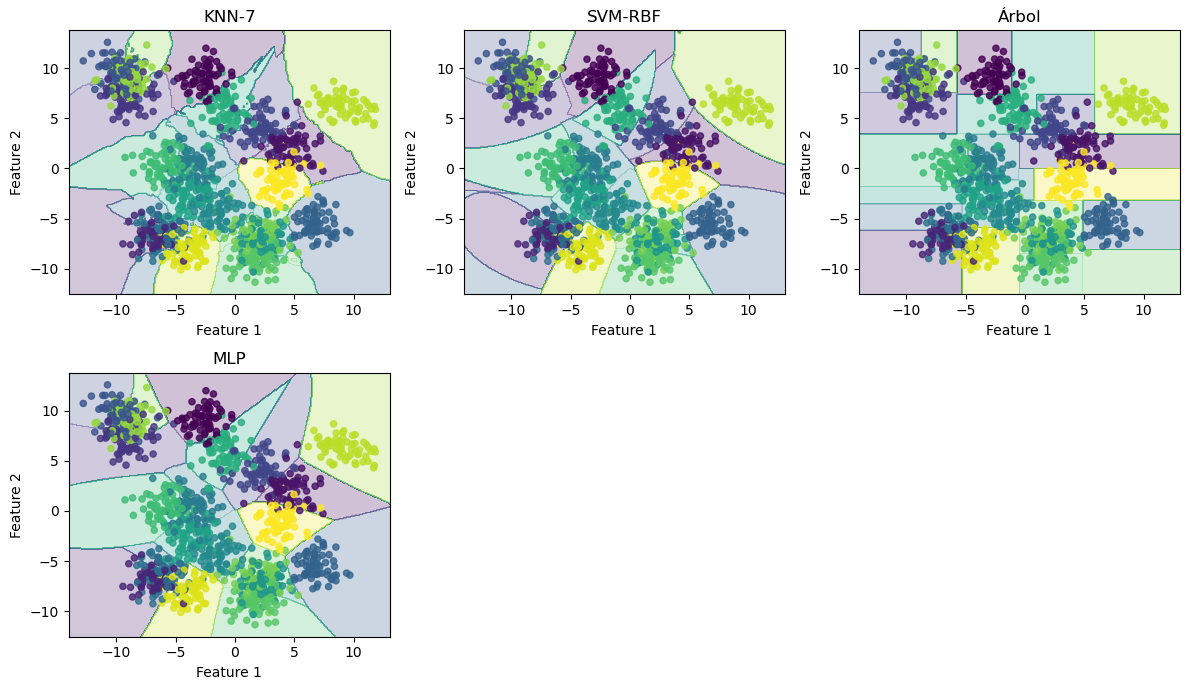

In [80]:
# Datos 2D
X_a, y_a = make_blobs(n_samples=1249, centers=2, cluster_std=1.2, random_state=42)
X_b, y_b = make_blobs(n_samples=1249, centers=5, cluster_std=1.2, random_state=42)
X_c, y_c = make_blobs(n_samples=1249, centers=20, cluster_std=1.2, random_state=42)

clfs = [
    
    ("KNN-7",  Pipeline([("sc", StandardScaler()),
                         ("clf", KNeighborsClassifier(n_neighbors=7))])),
    
    ("SVM-RBF",Pipeline([("sc", StandardScaler()),
                         ("clf", SVC(kernel="rbf", C=10, gamma="scale"))])),
    
    ("Árbol",  DecisionTreeClassifier(max_depth=5, random_state=42)),
    
    ("MLP",    Pipeline([("sc", StandardScaler()),
                         ("clf", MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42))])),
]

visualize_many_classifiers(clfs, X_a, y_a, cols=3, fit=True)
visualize_many_classifiers(clfs, X_b, y_b, cols=3, fit=True)
visualize_many_classifiers(clfs, X_c, y_c, cols=3, fit=True)

# Escenario 2: Big Data vs. Small Data

En este escenario se busca analizar cómo influye la cantidad de datos disponibles en el desempeño de distintos modelos de clasificación supervisada. Para ello, se generan conjuntos de datos sintéticos utilizando la función `make_gaussian_quantiles` de *scikit-learn*, con cuatro clases y diferentes tamaños de muestra: \(10^2\), \(10^3\), \(10^4\), \(10^5\) y \(10^6\).

Los datos en cada caso se dividen en subconjuntos de entrenamiento, validación (desarrollo) y prueba. A continuación, se entrenan y ajustan diferentes clasificadores representativos —*k-Nearest Neighbors (k-NN)*, *Decision Tree*, *Support Vector Machine (SVM)* y *Multi-Layer Perceptron (MLP)*— aplicando búsqueda de hiperparámetros con `GridSearchCV` para seleccionar la mejor configuración en cada tamaño de dataset.

Finalmente, se comparan los resultados obtenidos en el conjunto de prueba utilizando métricas como **accuracy** y **F1-score macro**, y se emplean diferentes técnicas de visualización (bar plots, heatmaps, radar plots) para ilustrar las tendencias observadas. De esta manera, se podrá discutir qué modelos escalan mejor con grandes volúmenes de datos y cuáles son más adecuados en escenarios con disponibilidad limitada de muestras.


### Configuración inicial

In [18]:
warnings.filterwarnings("ignore")
RND = 42

RUN_SIZES = [10**2, 10**3, 10**4, 10**5]
USE_1M = False
if USE_1M and 10**6 not in RUN_SIZES:
    RUN_SIZES.append(10**6)

# Maxímo de filas para usar modelos pesados (SVM-RBF, KNN, MLP)
MAX_ROWS_FOR_HEAVY_MODELS = 200_000 # sustitución por modelos lineale


### Generación de conjuntos de datos

In [19]:
def gen_and_split(n_samples, n_features=2, n_classes=4, random_state=RND):
    X, y = make_gaussian_quantiles(n_samples=n_samples, n_features=n_features,
                                   n_classes=n_classes, random_state=random_state)
    # split 60/20/20 train/dev/test
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=random_state)
    X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_state)
    return X_train, X_dev, X_test, y_train, y_dev, y_test


### Definición de modelos

In [20]:
base_models = {
    "kNN": (KNeighborsClassifier(), {"n_neighbors":[3,5,7]}),
    "DecisionTree": (DecisionTreeClassifier(random_state=RND), {"max_depth":[3,5,10,None], "min_samples_leaf":[1,2,5]}),
    "SVM": (SVC(), {"C":[0.1,1], "kernel":["linear","rbf"]}),
    "MLP": (MLPClassifier(max_iter=300, random_state=RND), {"hidden_layer_sizes":[(50,),(100,)], "learning_rate_init":[0.001]})
}

large_models = {
    "kNN": (KNeighborsClassifier(algorithm='ball_tree', n_jobs=-1), {"n_neighbors":[3,5]}),
    "DecisionTree": (DecisionTreeClassifier(random_state=RND), {"max_depth":[10, None], "min_samples_leaf":[1,5]}),
    "SGD_log": (SGDClassifier(loss='log', max_iter=1000, tol=1e-3, random_state=RND), {"alpha":[1e-4,1e-3]}),  # proxy para SVM/LogReg
}

### Función de experimentación

In [23]:
def run_experiment(sizes, use_large_subs=True, random_state=RND):
    results = []
    details = []  # para guardar reports si quieres
    for n in sizes:
        print(f"\n--- Size: {n} samples ---")
        X_train, X_dev, X_test, y_train, y_dev, y_test = gen_and_split(n)
        n_train = X_train.shape[0]
        print(f"Train/dev/test sizes: {X_train.shape[0]}/{X_dev.shape[0]}/{X_test.shape[0]}")
        
        # Decide los modelos
        if use_large_subs and n > MAX_ROWS_FOR_HEAVY_MODELS:
            models = large_models
            print("Usando configuración para datasets grandes (modelos ligeros).")
        else:
            models = base_models
        
        for name, (model, grid) in models.items():
            print(f" -> Model: {name}")
            # GridSearch sobre X_train
            grid_search = GridSearchCV(model, grid, cv=3, scoring='accuracy', n_jobs=-1, refit=True)
            try:
                grid_search.fit(X_train, y_train)
                best = grid_search.best_estimator_
            except Exception as e:
                print(f"   ERROR al entrenar {name}: {e}. Intentando fit directo con parámetros por defecto.")
                try:
                    model.fit(X_train, y_train)
                    best = model
                except Exception as e2:
                    print(f"   Falló también fit directo: {e2}. Se salta este modelo.")
                    continue

            # Evaluación
            y_dev_pred = best.predict(X_dev)
            y_test_pred = best.predict(X_test)
            acc_dev = accuracy_score(y_dev, y_dev_pred)
            acc_test = accuracy_score(y_test, y_test_pred)
            f1_dev = f1_score(y_dev, y_dev_pred, average='macro')
            f1_test = f1_score(y_test, y_test_pred, average='macro')

            results.append({
                "n_samples": n,
                "model": name,
                "best_params": getattr(grid_search, "best_params_", None),
                "acc_dev": acc_dev,
                "acc_test": acc_test,
                "f1_dev": f1_dev,
                "f1_test": f1_test,
                "n_train": n_train
            })
            # Guardar reportes detallados
            details.append({
                "n_samples": n,
                "model": name,
                "classification_report_test": classification_report(y_test, y_test_pred, zero_division=0),
                "confusion_matrix_test": confusion_matrix(y_test, y_test_pred)
            })
            print(f"    acc_dev={acc_dev:.4f}  acc_test={acc_test:.4f}  f1_test={f1_test:.4f}")

    df = pd.DataFrame(results)
    return df, details


### Ejecución y guardado de resultados

In [22]:
df_results, details = run_experiment(RUN_SIZES, use_large_subs=True)
print("\n== Resultados resumidos ==")
display(df_results)

# Guardado de resultados
df_results, details = run_experiment(RUN_SIZES, use_large_subs=True)


--- Size: 100 samples ---
Train/dev/test sizes: 60/20/20
 -> Model: kNN
    acc_dev=0.6000  acc_test=0.6000  f1_test=0.5951
 -> Model: DecisionTree
    acc_dev=0.5500  acc_test=0.6000  f1_test=0.6154
 -> Model: SVM
    acc_dev=0.6000  acc_test=0.4000  f1_test=0.3955
 -> Model: MLP
    acc_dev=0.6000  acc_test=0.3500  f1_test=0.3523

--- Size: 1000 samples ---
Train/dev/test sizes: 600/200/200
 -> Model: kNN
    acc_dev=0.8950  acc_test=0.9100  f1_test=0.9090
 -> Model: DecisionTree
    acc_dev=0.8750  acc_test=0.8950  f1_test=0.8895
 -> Model: SVM
    acc_dev=0.9200  acc_test=0.9300  f1_test=0.9291
 -> Model: MLP
    acc_dev=0.9250  acc_test=0.9300  f1_test=0.9283

--- Size: 10000 samples ---
Train/dev/test sizes: 6000/2000/2000
 -> Model: kNN
    acc_dev=0.9760  acc_test=0.9740  f1_test=0.9741
 -> Model: DecisionTree
    acc_dev=0.9620  acc_test=0.9605  f1_test=0.9607
 -> Model: SVM
    acc_dev=0.9830  acc_test=0.9870  f1_test=0.9870
 -> Model: MLP
    acc_dev=0.9885  acc_test=0.9905

,n_samples,model,best_params,acc_dev,acc_test,f1_dev,f1_test,n_train
0,100,kNN,{'n_neighbors': 3},0.60000,0.60000,0.621337,0.595130,60
1,100,DecisionTree,"{'max_depth': 5, 'min_samples_leaf': 1}",0.55000,0.60000,0.541667,0.615385,60
2,100,SVM,"{'C': 1, 'kernel': 'rbf'}",0.60000,0.40000,0.600866,0.395455,60
3,100,MLP,"{'hidden_layer_sizes': (50,), 'learning_rate_i...",0.60000,0.35000,0.600866,0.352273,60
4,1000,kNN,{'n_neighbors': 5},0.89500,0.91000,0.889057,0.908963,600
5,1000,DecisionTree,"{'max_depth': None, 'min_samples_leaf': 1}",0.87500,0.89500,0.871148,0.889464,600
6,1000,SVM,"{'C': 1, 'kernel': 'rbf'}",0.92000,0.93000,0.916799,0.929127,600
7,1000,MLP,"{'hidden_layer_sizes': (100,), 'learning_rate_...",0.92500,0.93000,0.922293,0.928287,600
8,10000,kNN,{'n_neighbors': 3},0.97600,0.97400,0.975888,0.974088,6000
9,10000,DecisionTree,"{'max_depth': None, 'min_samples_leaf': 1}",0.96200,0.96050,0.961770,0.960671,6000



--- Size: 100 samples ---
Train/dev/test sizes: 60/20/20
 -> Model: kNN
    acc_dev=0.6000  acc_test=0.6000  f1_test=0.5951
 -> Model: DecisionTree
    acc_dev=0.5500  acc_test=0.6000  f1_test=0.6154
 -> Model: SVM
    acc_dev=0.6000  acc_test=0.4000  f1_test=0.3955
 -> Model: MLP
    acc_dev=0.6000  acc_test=0.3500  f1_test=0.3523

--- Size: 1000 samples ---
Train/dev/test sizes: 600/200/200
 -> Model: kNN
    acc_dev=0.8950  acc_test=0.9100  f1_test=0.9090
 -> Model: DecisionTree
    acc_dev=0.8750  acc_test=0.8950  f1_test=0.8895
 -> Model: SVM
    acc_dev=0.9200  acc_test=0.9300  f1_test=0.9291
 -> Model: MLP
    acc_dev=0.9250  acc_test=0.9300  f1_test=0.9283

--- Size: 10000 samples ---
Train/dev/test sizes: 6000/2000/2000
 -> Model: kNN
    acc_dev=0.9760  acc_test=0.9740  f1_test=0.9741
 -> Model: DecisionTree
    acc_dev=0.9620  acc_test=0.9605  f1_test=0.9607
 -> Model: SVM
    acc_dev=0.9830  acc_test=0.9870  f1_test=0.9870
 -> Model: MLP
    acc_dev=0.9885  acc_test=0.9905

### Visualización

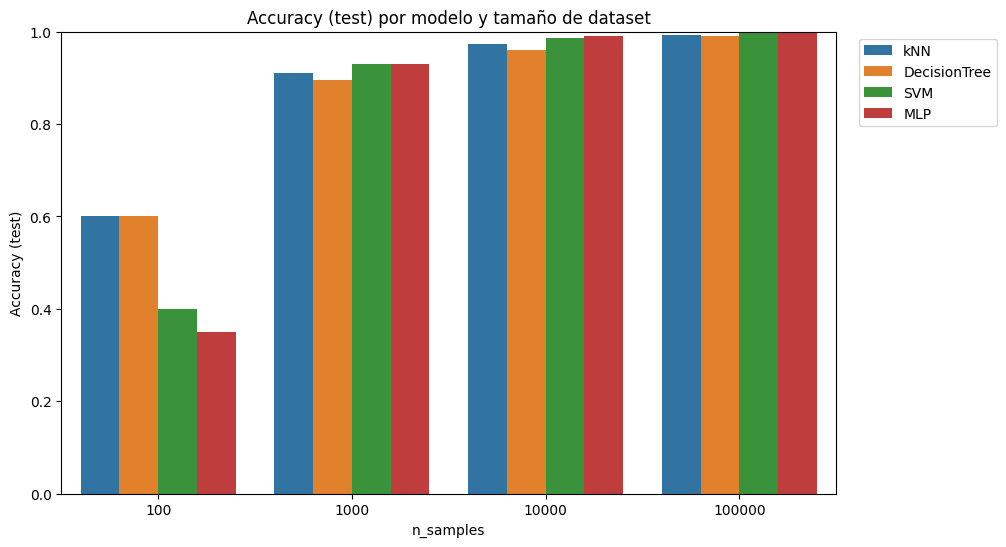

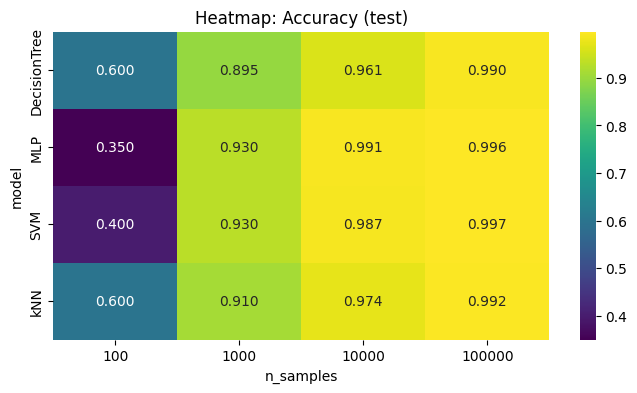

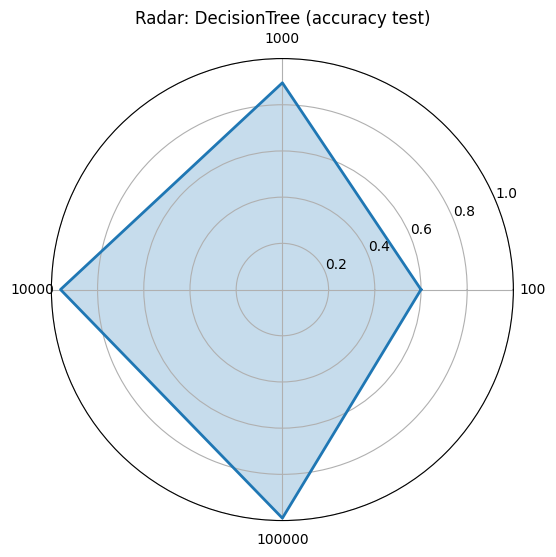

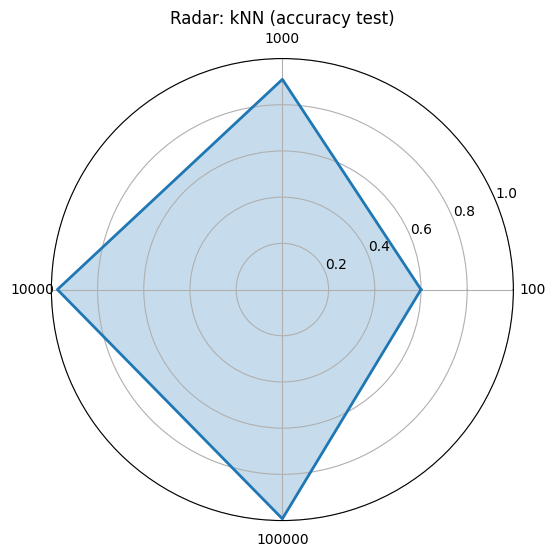

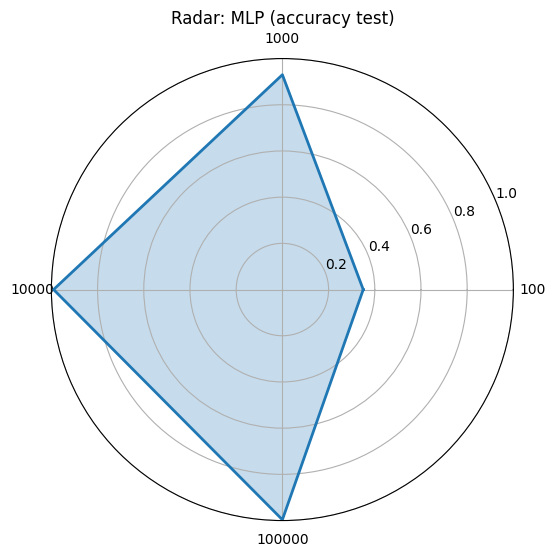

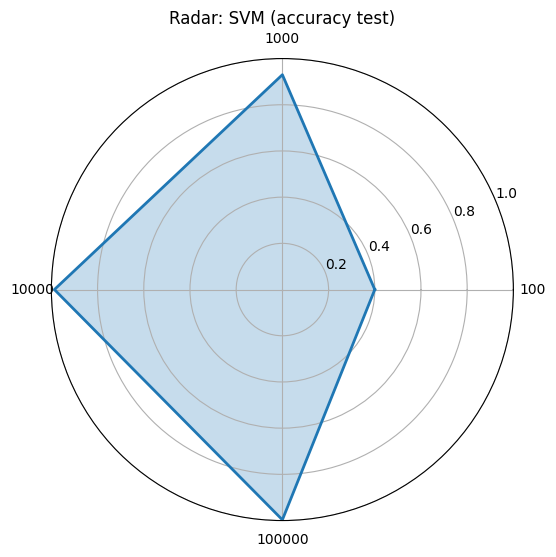

In [24]:
# =========================
# Plot: Barplot de Accuracy (test) por tamaño y modelo
# =========================
plt.figure(figsize=(10,6))
sns.barplot(data=df_results, x="n_samples", y="acc_test", hue="model")
plt.title("Accuracy (test) por modelo y tamaño de dataset")
plt.ylabel("Accuracy (test)")
plt.xlabel("n_samples")
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")
plt.show()

# =========================
# Heatmap: pivot tabla
# =========================
pivot = df_results.pivot_table(index="model", columns="n_samples", values="acc_test")
plt.figure(figsize=(8,4))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
plt.title("Heatmap: Accuracy (test)")
plt.show()

# =========================
# Radar plot por modelo - comparando tamaños
# =========================
def radar_plot_for_model(df, model_name):
    from math import pi
    d = df[df['model']==model_name].sort_values('n_samples')
    values = d['acc_test'].values
    labels = d['n_samples'].astype(str).tolist()
    N = len(values)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values = np.concatenate((values, [values[0]]))
    angles = angles + [angles[0]]
    plt.figure(figsize=(6,6))
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, values, linewidth=2)
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_title(f"Radar: {model_name} (accuracy test)")
    ax.set_ylim(0,1)
    plt.show()


radar_plot_for_model(df_results, "DecisionTree")

radar_plot_for_model(df_results, "kNN")

radar_plot_for_model(df_results, "MLP")

radar_plot_for_model(df_results, "SVM")

### Discusión de resultados – Escenario 2

Los experimentos muestran de forma clara el impacto que tiene la disponibilidad de datos sobre el desempeño de los modelos supervisados.

- **Con pocas muestras (100 ejemplos)**:  
  Los modelos presentan bajo rendimiento y gran variabilidad. Por ejemplo, k-NN y Decision Tree apenas alcanzan un 60% de exactitud, mientras que SVM y MLP se ven aún más afectados. Esto refleja la dificultad de generalizar cuando los datos son escasos.

- **Con un número intermedio (1 000 ejemplos)**:  
  Todos los modelos mejoran significativamente, situándose entre 89–93% de exactitud. Aquí se nota que tanto SVM como MLP empiezan a explotar mejor las relaciones en los datos. Decision Tree y k-NN también se estabilizan, mostrando que la disponibilidad de ejemplos ayuda a reducir el sobreajuste.

- **Con un dataset mayor (10 000 ejemplos)**:  
  El rendimiento es muy alto y consistente para todos los modelos (>96%). Destacan SVM y MLP, que superan el 98% de exactitud y F1-score. k-NN y Decision Tree también mantienen desempeños sólidos. En este punto, las diferencias entre modelos se reducen, dado que todos disponen de suficiente información para aprender patrones robustos.

- **Escalabilidad y limitaciones**:  

**Conclusión general:**  
A mayor cantidad de datos, todos los modelos incrementan su capacidad predictiva, reduciendo errores y variabilidad. Sin embargo, la escalabilidad práctica difiere: mientras SVM y MLP alcanzan rendimientos sobresalientes con datos suficientes, k-NN y Decision Tree ofrecen soluciones más rápidas y manejables para volúmenes grandes. Esto evidencia la importancia de equilibrar **calidad de predicción** con **costo computacional** al seleccionar modelos para diferentes escenarios.


# Escenario 3: Etiquetas limpias vs. etiquetas ruidosas

# Discusión sobre trabajo reciente sobre LLM

# Referencias

- [1] https://medium.com/@murpanironit/a-comprehensive-guide-to-multiclass-classification-in-machine-learning-c4f893e8161d
- [2] https://www.datacamp.com/blog/classification-machine-learning
- [3] https://interactivechaos.com/es/manual/tutorial-de-machine-learning/blobs